# Working with GPX-files in Python

By using numpy, pandas, SciKit-learn & gpxpy

a project by [Elian Van Cutsem](<http://www.elianvancutsem.com>)


## relative path to data-files

in the cell below you can define your own relative path to a folder with gpx files. This is the folder included in the repository.

In [3]:
dataPath = './sampleData/'

### test data and representative parts

In the variables below you can choose either all the files in your gpx-file folder should be used or just a preview with a few files. The latter is way more performant but less precise. You can edit how many files should be used and choose to ignore the testdata. These variables are used in further cells as well.

In [4]:
import warnings

maxFilesToUse = 100
useTestData = True

# hide futureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### imports

before you run this cell, make sure you have installed the gpxpy library in anaconda by running `pip install gpxpy` in the anaconda prompt. The other libraries mentioned below are automatically installed with [anaconda](<https://www.anaconda.com/>)


In [5]:
from collections import Counter
from datetime import timedelta
from matplotlib.pyplot import figure
from os import walk
from sklearn import datasets
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from copy import copy

import os
import statistics
import gpxpy.gpx
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn

# 1. Reading Data and visualising

## Reading the data

To edit and manipulate the given data, we first have to analyze how a gpx file is structured and can be used as a object in Python. In the first step below, we print out the files from the folder with the given gpx files. The code should be independable from any type of gpx file.

### Reading data from gpx files

The code below searches all files with a .gpx extension and puts them in a list. This list will later be used to effectively read data from the file with the name from the list. This step also makes use of the test data if you configured it. The test data variables will limit the number of files read by the code.

In [15]:
gpxFileList = []
numberOfFiles = 1
numberOfFilesInDirectory = 0

for (dirpath, dirnames, filenames) in walk(dataPath):
    numberOfFilesInDirectory = len(filenames)
    
    for file in filenames:
        if file.endswith('.gpx'):
            if numberOfFiles >= maxFilesToUse and useTestData:
                break
            else:
                gpxFileList.append(file)
            numberOfFiles += 1
            
print(f"number of .gpx files: {len(gpxFileList)}/{numberOfFiles}")
print("total number of files in directory:", numberOfFilesInDirectory)
print("total number of files looked at:", numberOfFiles)

number of .gpx files: 99/100
total number of files in directory: 4224
total number of files looked at: 100


### Transforming read data to a dataframe

Now that we know how many files we can use and we have a variable list `gpxFileList` with all the filenames, every file in that list can be opened and transformed to a gpx usable object in Python. Now that we have to read and calculate the object. It's a perfect time to calculate some basic features to select usable and trustworthy files on. We will filter all unrepresentative data and files out so we only keep good files for further use. Since a gps is never 100% accurate, some files become completely unusable and are beter ignored than used.
Since this step is quite intensive, it can take some time to calculate all the data. If it takes too long, you can limit the files in the variables initialized in the first few steps.

In [5]:
def hasHeartBeat(gpx):
    foundHr = 0
    for extensions in gpx.points[0].extensions:
        for extension in extensions:
            if extension.tag[-2:] == 'hr':
                foundHr = 1
                break
    return foundHr

In [ ]:
rawData = pd.DataFrame()

for file in gpxFileList:
    try:
        gpx_file = open(dataPath + file, 'r')
        gpx = gpxpy.parse(gpx_file)
        route = gpx.tracks[0]
        
        rawData = rawData.append({
            "filename": file,
            "file_id": file.split('_')[0],
            "creator": gpx.creator,
            "name": route.name,
            "date": route.get_time_bounds().start_time,
            "total distance": route.length_3d(),
            "total time": route.get_duration(),
            "nr of points": route.get_points_no(),
            "top speed": route.get_moving_data().max_speed,
            "has elevation": route.has_elevations(),
            "has heartbeat":  hasHeartBeat(route.segments[0]),
            "type": file.split('_')[1][:-4],
        }, ignore_index=True)
    
    except:
        pass

rawData

## filtering Data

### Filtering of data

Here we're looping the results of the previous cell and we're going to check if they are usable or not. The variables that define if they're usable are shown in the cell below. All unusable files are removed from the dataframe.

In [6]:
maxSpeed = 200
maxTime = timedelta(hours=24)
minTime = timedelta(minutes=5)
minNumberOfPoints = 8

In [ ]:
filteredData = pd.DataFrame()

for index, row in rawData.iterrows():
    error = 0
    try:
        if (row['totale tijd'] > maxTime.total_seconds()):
            error = 1
        elif (row['totale tijd'] < minTime.total_seconds()):
            error = 1
        elif row['aantal punten'] < minNumberOfPoints:
            error = 1
        elif (row['topsnelheid'] > maxSpeed):
            gpx_file = open(dataPath + row['filename'], 'r')
            gpx = gpxpy.parse(gpx_file)
            removedPoints = 0

            try:
                while gpx.get_moving_data().max_speed > maxSpeed:
                    points = gpx.tracks[0].segments[0].points
                    for i in range(0, len(points)-1):
                        punt = points[i-removedPoints]
                        volgendPunt = points[i+1-removedPoints]
                        speed = punt.speed_between(volgendPunt)
                        if speed > maxSpeed:
                            removedPoints += 1
                            del gpx.tracks[0].segments[0].points[i-removedPoints]
            except:
                error = 1
    except:
        error = 1
        
    if error == 0:
        filteredData = filteredData.append(row)

print('number of removed files:', str(len([name for name in os.listdir(dataPath)])-len(filteredData)))

filteredData = filteredData.reset_index()

filteredData

### Save data as a csv-file

Since it can take a lot of time to calculate all files, we make a csv file with all info we calculated so we can reuse all data without recalculating.

In [ ]:
filteredData.to_csv('filesTest.csv') if useTestData else filteredData.to_csv('files.csv')
print('Saved!')

## Looking at individual files

Now that only representative data is left, we can take a look at how a file is structured and what is stored in a GPX-file. We can translate all this info to charts.

### Reading the data from the previous made CSV-file

Here we read all data from the CSV-file that was previously created. This step can be skipped if all data was calculated on the same kernel. It never does harm to execute the cell below.

In [7]:
filteredData = pd.read_csv('filesTest.csv') if useTestData else pd.read_csv('files.csv')
print('Read all data!')

Ingelezen!


### Interpretation of a random file

In the cell below we select a random file from the filtered data. Then we take a look at what info is stored the GPX object.

In [9]:
rand = random.randrange(len(filteredData))
file = filteredData["filename"][rand]
gpx_file = open(dataPath + file, 'r')
gpx = gpxpy.parse(gpx_file)
print(gpx.to_xml())

<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd" version="1.1" creator="RouteYou">
  <trk>
    <name>Afternoon Run</name>
    <trkseg>
      <trkpt lat="51.41936" lon="4.359775">
        <ele>23.4</ele>
        <time>2019-03-15T13:02:06Z</time>
        <extensions>
          <gpxtpx:TrackPointExtension>
            <gpxtpx:hr>71</gpxtpx:hr>
            <gpxtpx:speed>0</gpxtpx:speed>
          </gpxtpx:TrackPointExtension>
        </extensions>
      </trkpt>
      <trkpt lat="51.419346" lon="4.359772">
        <ele>23.4</ele>
        <time>2019-03-15T13:02:07Z</time>
        <extensions>
          <gpxtpx:TrackPointExtension>
            <gpxtpx:hr>71</gpxtpx:hr>
            <gpxtpx:speed>0</gpxtpx:speed>
          </gpxtpx:TrackPo

In [10]:
print("File: " +  filteredData["filename"][rand])
print("Creator of the track: " + gpx.creator)

for track in gpx.tracks:
    print("track name: " + track.name)
    print("number of points in the segment: ", gpx.get_points_no())
    print("length of the route " + str(round(gpx.length_2d() / 1000,2)) + 'km')
    print("first point in the segment: ", gpx.get_time_bounds().start_time)
    print("last point in the segment: ",  gpx.get_time_bounds().end_time)
    print("total time in seconds: ", track.get_duration())
        

File: 6045842_9.gpx
Creator van de track: RouteYou
track name: Afternoon Run
aantal punten in segment:  5186
lengte van de route 11.96km
eerste punt in segment:  2019-03-15 13:02:06+00:00
laatste punt in segment:  2019-03-15 14:28:24+00:00
totale tijd in seconden:  5178.0


### charts we can create by using a random file

If we have access to all points in a file, we can construct a chart which will match the route in the GPX object. Some files also have elevation data, speed data and heartrate data. If we have these, they also can be translated to a chart. (but not all files have these)

File: 6045842_9.gpx


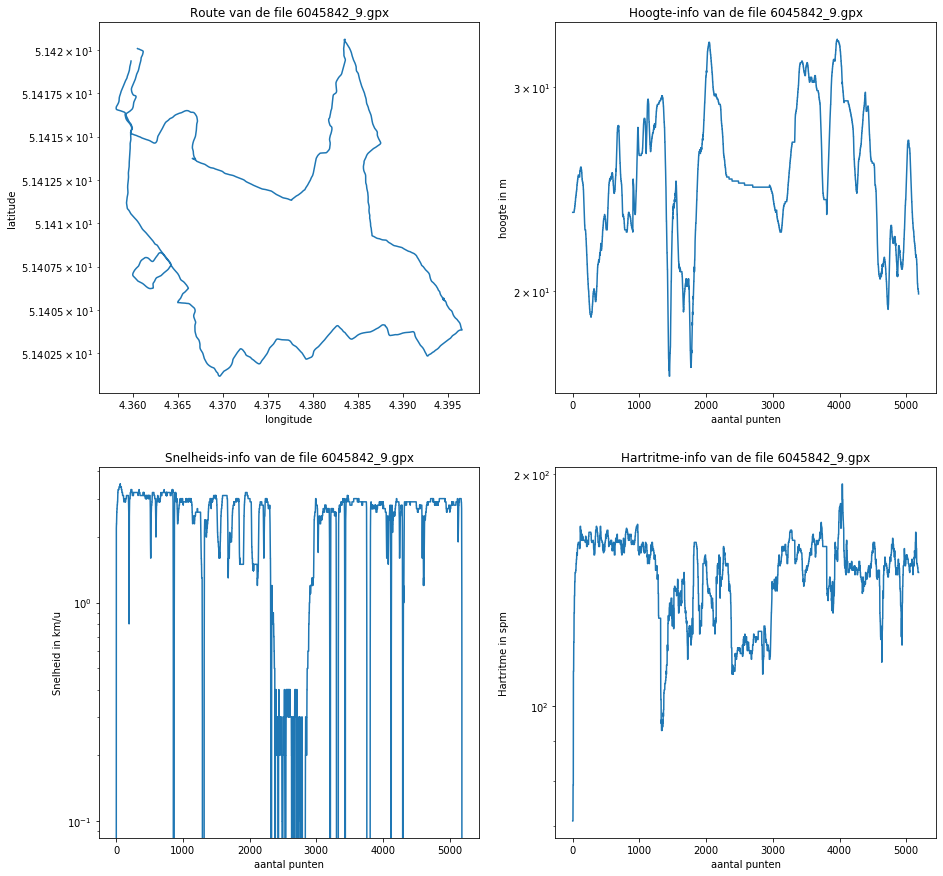

In [11]:
lon = []
lat = []
height = []
speed = []
hr = []

print("File: " + file)
points = gpx.tracks[0].segments[0].points
for point in points:
    lon.append(float(point.longitude))
    lat.append(float(point.latitude))
    if point.elevation is not None:
        height.append(point.elevation)
    for extensions in point.extensions:
        for extension in extensions:
            if extension.tag[-5:] == 'speed':
                speed.append(float(extension.text))
            if extension.tag[-2:] == 'hr':
                            hr.append(float(extension.text))

fig, axs = plt.subplots(2,2, figsize=(15,15))

axs[0][0].semilogy(lon, lat)
axs[0][0].set_xlabel('longitude')
axs[0][0].set_ylabel('latitude')
axs[0][0].set_title('Route of the file {}'.format(file))
try:
    axs[0][1].semilogy(range(0, len(points)), height)
    axs[0][1].set_xlabel('number of points')
    axs[0][1].set_ylabel('height in m')
    axs[0][1].set_title('height-info of the file {}'.format(file))
except:
    print('this file doesn\'t contain any height data')
try:
    axs[1][0].semilogy(range(0, len(points)), speed)
    axs[1][0].set_xlabel('number of points')
    axs[1][0].set_ylabel('speed in km/u')
    axs[1][0].set_title('speed data of the file {}'.format(file))
except:
    print('this file doesn\'t contain any speed data')
try:
    axs[1][1].semilogy(range(0, len(points)), hr)
    axs[1][1].set_xlabel('number of points')
    axs[1][1].set_ylabel('Hearteate in bpm')
    axs[1][1].set_title('Heartrate data of the file {}'.format(file))
except:
    print('this file doesn\'t contain any heartrate data')

### simplifying the route

We can simplify the route using a point-reduction algorithm. This is the algorithm used:[Ramer-Douglas-Peucker algorithm](<http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm>)

Text(0, 0.5, 'latitude')

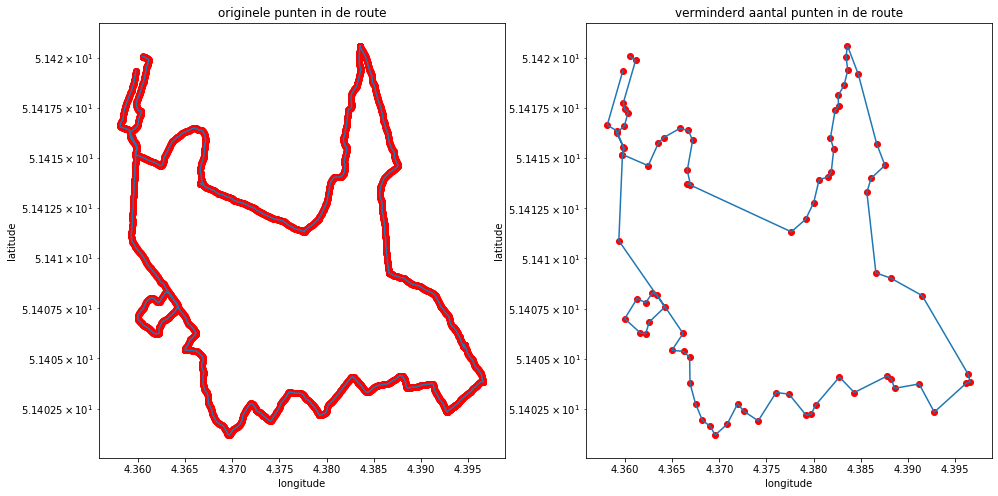

In [12]:
simpleGpx = copy(gpx)
simpleGpx.tracks[0].segments[0].simplify()
smoothLon = []
smoothLat = []

for punt in simpleGpx.tracks[0].segments[0].points:
    smoothLon.append(punt.longitude)
    smoothLat.append(punt.latitude)

fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].semilogy(lon, lat)
axs[0].scatter(lon, lat, c='r')
axs[0].set_title('original points in route')
axs[1].semilogy(smoothLon, smoothLat)
axs[1].scatter(smoothLon, smoothLat, c='r')
axs[1].set_title('simplified points in route')
axs[0].set_xlabel('longitude')
axs[0].set_ylabel('latitude')
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('latitude')

### comparing more random files

In the cell below we compare some random files. You can change the number of files used by changing the variable `numberOfFilesUsed`.

In [13]:
numberOfFilesUsed = 8
numberOfPoints = 0
time = 0
heigthInfo = 0
timeInfo = 0

for randomFile in range(numberOfFilesUsed):
    rand = random.randrange(len(filteredData)-1)
    file = filteredData["filename"][rand]
    gpx_file = open(dataPath + file, 'r')
    gpx = gpxpy.parse(gpx_file)
    time += gpx.get_duration()
    heigthInfo += gpx.has_elevations()
    timeInfo += gpx.has_times()
    numberOfPoints += gpx.tracks[0].segments[0].get_points_no()
                
print("\nnumber of files analyzed: " + str(numberOfFilesUsed))
print("avarage time in a route: {} seconds".format(time/numberOfFilesUsed))
print("number of files with height info:", heigthInfo)
print("number of files with time info: ", timeInfo)
print("average number of points in a file: " + str(numberOfPoints/numberOfFilesUsed) + "\n")


aantal files geanaliseerd: 8
gemiddelde duur van een route: 5981.75 seconden
aantal files met hoogte info: 5
aantal files met tijd info:  8
gemiddeld aantal punten per file: 1686.75



### info

below some charts about how the data is devided across the files.

#### representative data

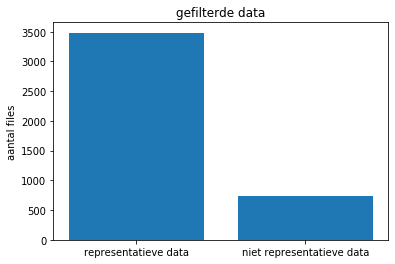

In [16]:
labels = ('representative data', 'not-representative data')
numbers = (len(filteredData), (numberOfFiles)-len(filteredData))

plt.bar(labels, numbers)
plt.ylabel('number of files')
plt.title('filtered data')

plt.show()

#### Height data

Er zijn 1674 files met hoogte informatie. op 3484 files
Dat is 48.04822043628014%


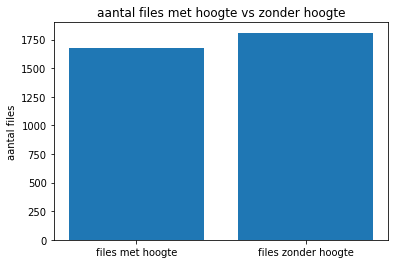

In [17]:
numberOfFilesWithHeight = 0

for file in filteredData["has height"]:
    if file == 1:
        numberOfFilesWithHeight += 1
        
print('there are ' + str(numberOfFilesWithHeight) + ' files with height data out of {} files'.format(len(filteredData)))
print('that\'s ' + str(numberOfFilesWithHeight/len(filteredData)*100) + '%')

labels = ('files with height data', 'files without height data')
numbers = (numberOfFilesWithHeight, (len(filteredData)-numberOfFilesWithHeight))
y = labels

plt.bar(y, numbers)
plt.ylabel('number of files')
plt.title('number of files with height vs without height')
plt.show()

#### Heart rate data

Er zijn 999 files met hoogte informatie. op 3484 files
Dat is 28.67%


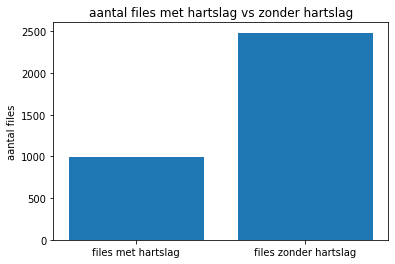

In [18]:
numberOfFilesWithHeartrate = 0

for file in filteredData["has heartbeat"]:
    if file > 0:
        numberOfFilesWithHeartrate += 1
        
print('there\'s {} files with height data on {} files'.format(numberOfFilesWithHeartrate,len(filteredData)))
print('that\'s {:.2f}%'.format(numberOfFilesWithHeartrate/len(filteredData)*100))

labels = ('files with hartrate', 'files without heartrate')
numbers = (numberOfFilesWithHeartrate, (len(filteredData)-numberOfFilesWithHeartrate))
y = labels

plt.bar(y, numbers)
plt.xticks(y, labels)
plt.ylabel('number of files')
plt.title('number of files with heartrate vs without heartrate')
plt.show()

## Verdeling van target

in dit project wordt het type van de route als target genomen. Hieronder bevindt zich een studie over het type van een route.

### mogelijke types

Er werd in de datamap een file meegegeven met alle opgelijste types. Hieronder zijn de 10 eerste records van die file te zien.

In [19]:
types = pd.DataFrame(data=pd.read_csv(dataPath + "/routeTypes.txt", sep='\t', index_col=0))
types.head(10)

,type,level,lower_limit,upper_limit
id,,,,
0,all,0,1,25000
1,bike,1,1,5000
2,walk,1,5001,10000
4,other,1,15001,25000
5,recreational cycling,2,1,1000
6,race cycling,2,1001,2000
7,mountain biken,2,2001,3000
8,recreational walking,2,5001,6000
9,running,2,6001,7000


### aantal files per type uit features

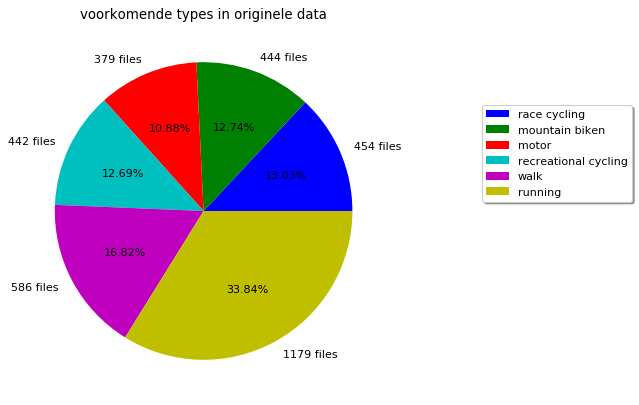

hier nog een barchart:


Text(0, 0.5, 'aantal files')

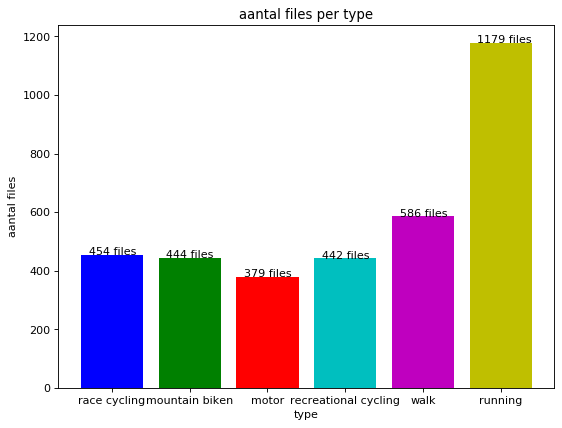

In [20]:
counts = Counter(filteredData['type'])

labels = [types.type[int(label)] for label in counts]
figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pie([float(value) for value in counts.values()],
        labels=[str(value) + ' files' for value in counts.values()],
        autopct='%1.2f%%', colors='bgrcmy')
plt.title("voorkomende types in originele data")
plt.legend(labels, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show()

print('hier nog een barchart:')
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bars = plt.bar(labels, counts.values(), color='bgrcmy')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.1, yval, str(yval) + ' files')
plt.title("aantal files per type")
plt.xlabel("type")
plt.ylabel('aantal files')


Er is duidelijk te zien dat bijlange na niet alle beschikbare types gebezigd worden in de data. Deze types moeten dus niet berekend worden.De enige die gebruikt worden worden hieronder weergeven:

In [21]:
types['type'][[key for key in Counter(filteredData['type']).keys()]]

id
6            race cycling
7          mountain biken
3                   motor
5    recreational cycling
2                    walk
9                 running
Name: type, dtype: object

# 2. Features bepalen en berekenen

## Motivatie bij features

Hierbij wat uitleg bij de keuze van de features

### gebruikte features:

 - **Totale afstand**: Deze feature is zeer gemakkelijk te berekenen via de ingebouwde functie. Het is dan ook een logische feature om te hebben aangezien een wandelaar niet zo ver zal stappen als een fietser zal fietsen.
 - **Totale tijd**: De totale tijd kan ook berekend worden via een interne functie. Deze wordt ook gebruikt om data te filteren. Het is ook een goede feature.
 - **topsnelheid**: De topsnelheid kan berekend worden via een interne functie en is een goede feature omdat een wandelaar geen 20Km/u stapt, maar een fietser wel 20km/u kan fietsen. Dit is dus een gemakkelijke feature om data aan te herkennen.
 - **minimale snelheid**: De minimale snelheid is een goede feature, maar correleerd met de topsnelheid. De minimale snelheid is ook vaak 0 of 1 omdat stilstand natuurlijk ook een 'snelheid' is.
 - **minimale hoogte**: De minimale hoogte kan rechtstreeks uit de route gehaald worden met een interne functie.
 - **Totale stijging**: De totale stijging kan ook uit de library gehaald worden.
 - **gemiddelde hartslag**: De gemiddelde hartslag wordt enkel berekend bij routes die deze info bevatten. Het is daarom misschien een iets minder relevante feature.
 - **totaal aantal hartslagen**: Deze corelleerd hoog met andere features omtrent hartslagen, maar niet genoeg om deze achterwege te laten.
 - **totale stijging**: Deze feature kan ook enkel berekend worden bij routes die deze info bevat, maar is wel handig.
 - **gemiddelde afstand tussen 2 punten**:
 - **afstand tussen eerste en laatste punt**: Deze zelfgeschreven feature berekent hoe ver het allereerste en laatste punt uit elkaar liggen. Dit kan handig zijn om te checken of er in een rondje is gereden of niet. 
 - **gemiddeld aantal punten per kilometer**:
 - **maand van de route**: Deze feature bekijkt in welke maand de route valt. Dit kan handig zijn om rekening te houden dat er bv. meer fieters in de zomer zijn, dan in de winter.
 - **seizoen**: deze feature correleerd zeer sterk met de maand feature. Deze feature deelt de maanden op in 4 kwartalen. Er zouden bijvoorbeeld minder fietsers kunnen zijn in de winter dan wandelaars.
 - **startuur van de route**: Deze feature toont via een interne functie het uur van de start van de route. Deze feature zou handig kunnen zijn indien fietsers liever een ochtendritje maken of motorijders een avondrit.
 - **is weekend**: Deze feature berekend of de dag een weekend is of niet. Dit kan handig zijn bv. recreatieve routes vallen misschien meer in weekends dan weekdagen.
 - **Maximale hartslag**: deze feature berekent de maximale hartslag uit alle punten. **Let op** Ruimweg 2/3de van alle databestanden bevatten geen hartslaginformatie.
 - **Mediaan van de snelheid**: deze functie bekijkt alle snelheden van alle punten en neemt de mediaan van deze snelheden.
 - **Standaard-afwijking v/d snelheid**: Deze berekening berekend de extreme afwijkingen en geeft een getal terug.
 - **Heeft cadence**: Deze extensie geeft het aantal stappen per minuut weer. Deze feature is zeer handig aangezien een fietser nooit cadence heeft.


## features berekenen

### code om eigen features te berekenen

In [22]:
def isWeekend(gpx):
    return 1 if gpx.points[0].time.weekday() >= 5 else 0

def getLowSpeed(gpx):
    topSpeed = gpx.get_moving_data().max_speed
    for i in range(len(gpx.points)-1):
        point = gpx.points[i]
        speed = point.speed_between(gpx.points[i + 1])
        if speed is None:
            return 0
        elif speed < topSpeed:
            topSpeed = speed
            
    return topSpeed

def getMediaanSnelheid(gpx):
    speed = []
    for i in range(len(gpx.points)-1):
        point = gpx.points[i]
        speed.append(point.speed_between(gpx.points[i + 1]))
    try:
        return statistics.median(speed)
    except:
        return 0

def getGemiddeldeSnelheid(gpx):
    n = len(gpx.points)
    snelheden = []
    speed = 0
    
    for i in range(len(gpx.points)-1):
        point = gpx.points[i]
        snelheid = point.speed_between(gpx.points[i + 1])
        if snelheid is not None:
            snelheden.append(point.speed_between(gpx.points[i + 1]))
            speed += point.speed_between(gpx.points[i + 1])
        else:
            n -= 1
    
    return speed / n
    
#https://nl.wikihow.com/Standaardafwijking-berekenen
def getAfwijking(gpx):
    n = len(gpx.points)
    snelheden = []
    speed = 0
    variantie = []
    variantieNummer = 0
    
    for i in range(len(gpx.points)-1):
        point = gpx.points[i]
        snelheid = point.speed_between(gpx.points[i + 1])
        if snelheid is not None:
            snelheden.append(point.speed_between(gpx.points[i + 1]))
            speed += point.speed_between(gpx.points[i + 1])
        else:
            n -= 1
    
    gemiddelde = speed / n
    
    for speed in snelheden:
        variantie.append((speed - gemiddelde)**2)
        
    for number in variantie:
        variantieNummer += number
        
    return variantieNummer / (n-1)

def getHighBpm(gpx):
    hr = 0
    for punt in gpx.points:
        for extensions in punt.extensions:
            for extension in extensions:
                if extension.tag[-2:] == 'hr':
                    if float(extension.text) > hr:
                        hr = float(extension.text)
    return hr

def getLowBpm(gpx):
    hr = getHighBpm(gpx)
    for punt in gpx.points:
        for extensions in punt.extensions:
            for extension in extensions:
                if extension.tag[-2:] == 'hr':
                    if float(extension.text) < hr:
                        hr = float(extension.text)
    return hr

def puntenPerMin(gpx):
    punten = len(gpx.points)
    tijd = gpx.get_duration()
    if tijd is None or tijd == 0:
        return 0
    return punten / tijd

def getGemiddeldeAfstandTussenPunten(gpx):
    afstand = gpx.length_3d()
    return afstand / gpx.get_points_no()

def getStartEndDistance(gpx):
    afstand = 0
    eerstePunt = gpx.points[0]
    tweedePunt = gpx.points[len(gpx.points)-1]
    afstand = eerstePunt.course_between(tweedePunt)
    return afstand

def hasCadence(gpx):
    foundCad = 0
    for extensions in gpx.points[0].extensions:
        for extension in extensions:
            if extension.tag[-3:] == 'cad':
                foundCad = 1
                break
    return foundCad

**Opgelet** Deze berekeningen kunnen even duren.

In [ ]:
features = pd.DataFrame()

for index, row in filteredData.iterrows():
    file = '{}_{}.gpx'.format(int(row['file_id']),int(row['type']))
    gpx_file = open(dataPath + file, 'r')
    gpx = gpxpy.parse(gpx_file)
    track = gpx.tracks[0].segments[0]

    features = features.append({
            "totale afstand": track.length_3d(),
            "totale tijd": track.get_duration(),
            "type": row["type"],
            "topsnelheid": track.get_moving_data().max_speed,
            "min snelheid": getLowSpeed(track),
            "min hoogte": track.get_elevation_extremes().minimum if track.get_elevation_extremes().minimum is not None else 0,
            "totale stijging": track.get_uphill_downhill().uphill,
            "gemiddelde afstand tussen 2 punten": getGemiddeldeAfstandTussenPunten(track),
            "afstand tussen eerste en laatse punt": getStartEndDistance(track),
            "gem punten per minuut": puntenPerMin(track),
            "maand": str(track.get_time_bounds().start_time.month),
            "seizoen": str(int(track.get_time_bounds().start_time.month / 4)),
            "startuur": str(track.get_time_bounds().start_time.hour),
            "isWeekend": isWeekend(track),
            "max hartslag": getHighBpm(track),
            "mediaan van snelheid": getMediaanSnelheid(track),
            "standaardafwijking in snelheid": getAfwijking(track),
            "heeft cadence": hasCadence(track),        
            "max hoogte": track.get_elevation_extremes().maximum if track.get_elevation_extremes().maximum is not None else 0,
            "min hartsnelheid": getLowBpm(track),
            "gem snelheid": getGemiddeldeSnelheid(track),
        }, ignore_index=True)
    
features

## features opslaan als csv

In [ ]:
features.to_csv('featuresTest.csv') if useTestData else features.to_csv('features.csv')
print('opgeslaan!')

# 3. Feature evaluatie en selectie

## Features inlezen van csv

In [23]:
features = pd.read_csv('featuresTest.csv') if useTestData else pd.read_csv('features.csv')
features = features.drop(['Unnamed: 0'], axis=1)
print('features ingelezen!')

features ingelezen!


## Features bekijken
voor meer info omtrent het motiveren en weglaten van features zie [Motivatie bij features](<#Motivatie-bij-features>)

In [24]:
features

,afstand tussen eerste en laatse punt,gem punten per minuut,gem snelheid,gemiddelde afstand tussen 2 punten,heeft cadence,isWeekend,maand,max hartslag,max hoogte,mediaan van snelheid,...,min hoogte,min snelheid,seizoen,standaardafwijking in snelheid,startuur,topsnelheid,totale afstand,totale stijging,totale tijd,type
0,226.054057,0.029654,6.387039,102.891400,0.0,0.0,2,0.0,0.0,6.959222,...,0.0,0.326103,0,2.739020,11,7.920486,37452.469736,0.0,12275.0,6
1,268.613362,0.001319,2.368054,22.116757,0.0,1.0,1,0.0,0.0,2.264796,...,0.0,0.000232,0,3.689560,9,5.178630,707.736208,0.0,24254.0,6
2,138.715569,0.151095,5.692224,36.384630,0.0,0.0,2,0.0,0.0,4.243585,...,0.0,0.500685,0,90.853387,0,7.311748,7531.618359,0.0,1370.0,7
3,3.018412,0.033670,20.213824,575.845465,0.0,1.0,2,0.0,0.0,18.669175,...,0.0,0.068671,0,281.873716,13,33.923854,74859.910386,0.0,3861.0,3
4,289.983620,0.100131,12.734479,127.294765,0.0,1.0,2,0.0,0.0,12.983868,...,0.0,1.191647,0,10.884349,14,16.723931,19476.098985,0.0,1528.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,24.040793,0.115439,15.135401,95.974792,0.0,0.0,7,0.0,0.0,15.322318,...,0.0,0.012455,1,40.876428,10,22.037669,117473.145516,0.0,10603.0,3
3480,267.058139,0.143030,15.132608,97.060220,0.0,0.0,7,0.0,0.0,15.355255,...,0.0,0.426158,1,39.592917,14,21.565489,34456.378050,0.0,2482.0,3
3481,258.436175,0.130866,11.201622,42.541346,0.0,0.0,7,0.0,0.0,10.742112,...,0.0,0.020978,1,24.276488,14,16.317776,25269.559659,0.0,4539.0,3
3482,132.933468,0.214565,13.813522,51.360321,0.0,1.0,2,0.0,0.0,13.963284,...,0.0,0.141650,0,21.264933,12,19.097986,36619.909216,0.0,3323.0,3


## Correlatie matrix

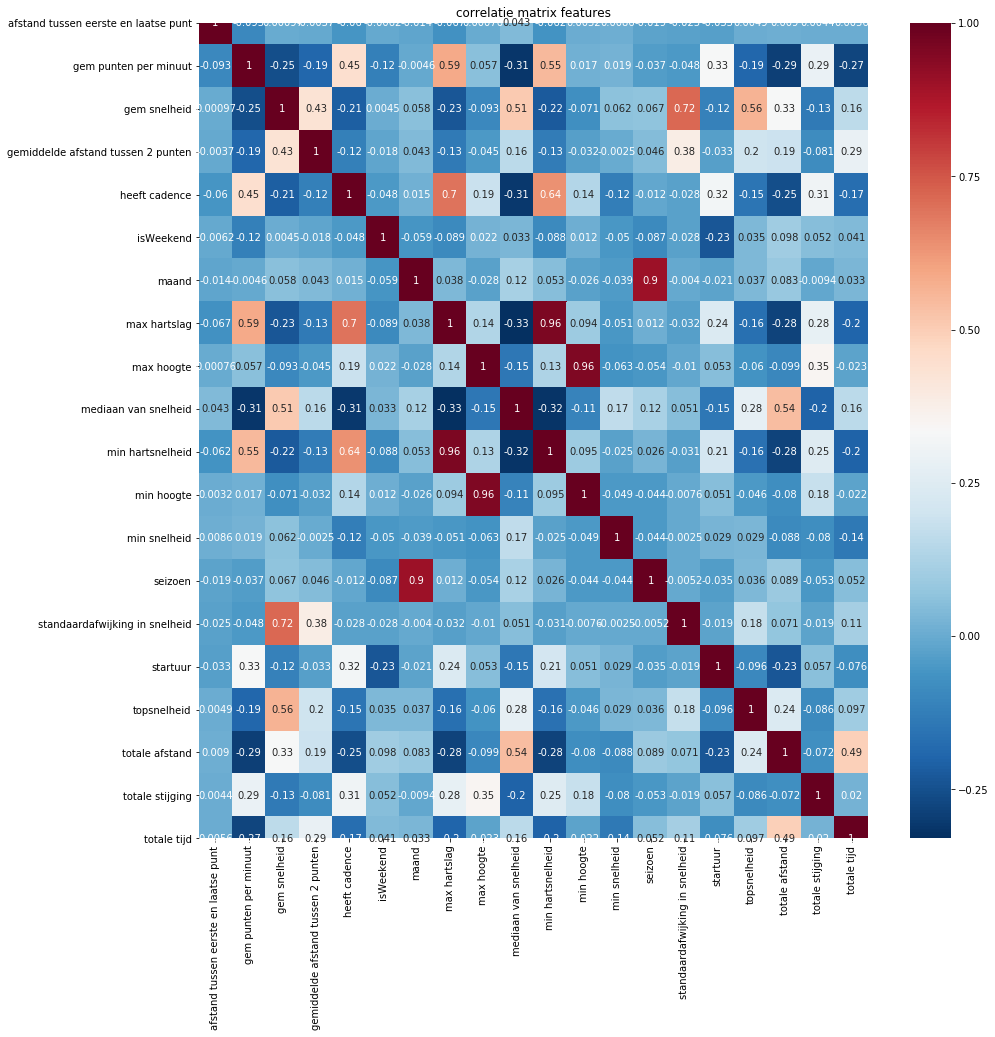

In [25]:
correlationMatrix = features.drop(['type'], axis=1).corr()
plt.figure(figsize=(15,15))
plt.title('correlatie matrix features')
seaborn.heatmap(correlationMatrix, annot=True, cmap="RdBu_r")
plt.show()

# 4. Opstellen van meerdere modellen

## instellen van data en Target

In [26]:
y = features['type'].to_numpy().astype(int)
X = features.drop(['type'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=40, test_size=0.3)

In [27]:
#print(y)
X

,afstand tussen eerste en laatse punt,gem punten per minuut,gem snelheid,gemiddelde afstand tussen 2 punten,heeft cadence,isWeekend,maand,max hartslag,max hoogte,mediaan van snelheid,min hartsnelheid,min hoogte,min snelheid,seizoen,standaardafwijking in snelheid,startuur,topsnelheid,totale afstand,totale stijging,totale tijd
0,226.054057,0.029654,6.387039,102.891400,0.0,0.0,2,0.0,0.0,6.959222,0.0,0.0,0.326103,0,2.739020,11,7.920486,37452.469736,0.0,12275.0
1,268.613362,0.001319,2.368054,22.116757,0.0,1.0,1,0.0,0.0,2.264796,0.0,0.0,0.000232,0,3.689560,9,5.178630,707.736208,0.0,24254.0
2,138.715569,0.151095,5.692224,36.384630,0.0,0.0,2,0.0,0.0,4.243585,0.0,0.0,0.500685,0,90.853387,0,7.311748,7531.618359,0.0,1370.0
3,3.018412,0.033670,20.213824,575.845465,0.0,1.0,2,0.0,0.0,18.669175,0.0,0.0,0.068671,0,281.873716,13,33.923854,74859.910386,0.0,3861.0
4,289.983620,0.100131,12.734479,127.294765,0.0,1.0,2,0.0,0.0,12.983868,0.0,0.0,1.191647,0,10.884349,14,16.723931,19476.098985,0.0,1528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,24.040793,0.115439,15.135401,95.974792,0.0,0.0,7,0.0,0.0,15.322318,0.0,0.0,0.012455,1,40.876428,10,22.037669,117473.145516,0.0,10603.0
3480,267.058139,0.143030,15.132608,97.060220,0.0,0.0,7,0.0,0.0,15.355255,0.0,0.0,0.426158,1,39.592917,14,21.565489,34456.378050,0.0,2482.0
3481,258.436175,0.130866,11.201622,42.541346,0.0,0.0,7,0.0,0.0,10.742112,0.0,0.0,0.020978,1,24.276488,14,16.317776,25269.559659,0.0,4539.0
3482,132.933468,0.214565,13.813522,51.360321,0.0,1.0,2,0.0,0.0,13.963284,0.0,0.0,0.141650,0,21.264933,12,19.097986,36619.909216,0.0,3323.0


In [28]:
print("Shape of data:", X.shape)
print("Shape of target:", y.shape)

Shape of data: (3484, 20)
Shape of target: (3484,)


In [29]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("aantal features is dus:", X.shape[1])

X_train shape: (2438, 20)
y_train shape: (2438,)
X_test shape: (1046, 20)
y_test shape: (1046,)
aantal features is dus: 20


## Selectie van modellen

waarom heb ik deze modellen gekozen

### KNN-model

Knn is een zeer simpel model. Het model onthoud alle gegeven trainings data. Wanneer dan een voorspelling moet gebeuren zoekt het model de dichts-bijzijnde buur. Dit model kan wel getuned worden met het aantal buren waarmee het rekening moet houden.

### Decision trees modellen

Decision tree modellen kunnen zeer gedetaileerd zijn, maar nemen wat meer tijd in beslag dan een KNN of linear model.

## bewust niet gebruiken van modellen
waarom heb ik deze modellen niet gekozen

### linear model

naastdat er met een linear model een enorm slechte score gehaald wordt. Is deze niet representatief. Uit de data en de features is zeer goed te zien dat de data niet linear te onderscheiden is. Daarom wordt dit model niet verder gebruikt in dit project.

testing score: 27.72%


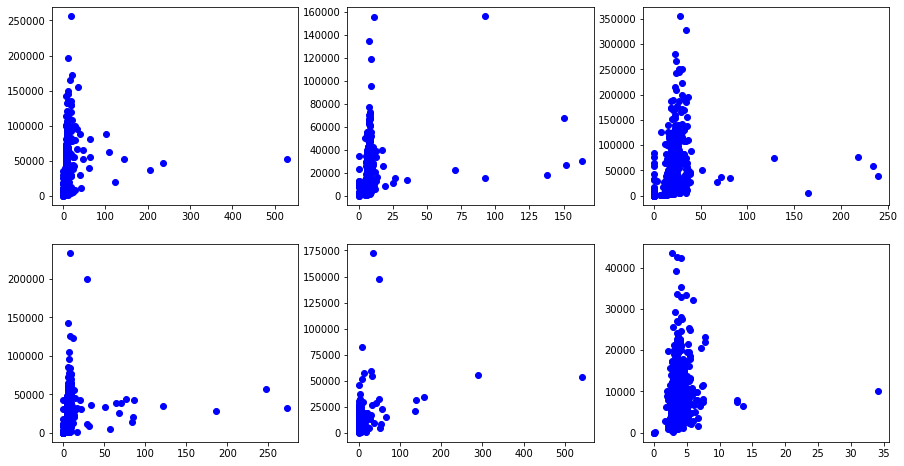

In [30]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
newTypes = [value for value in counts.keys()]
counts = Counter(features['type'])
for i in features.index:
    ax = axs[newTypes.index(features['type'][i]) // 3, newTypes.index(features['type'][i]) % 3]
    ax.plot(features['topsnelheid'][i], features['totale afstand'][i], 'bo')

lr = LinearRegression().fit(X_train, y_train)

print('testing score: ' + str(round(lr.score(X_test, y_test) * 100, 2)) + '%')

### K-means

hieronder is te zien hoe een kmeans zou berekend kunnen worden, maar dit is eigenlijk niet relevant binnen dit project omdat K-means vooral op zoek gaat naar clusters, deze clusters bestaan niet echt met deze features.

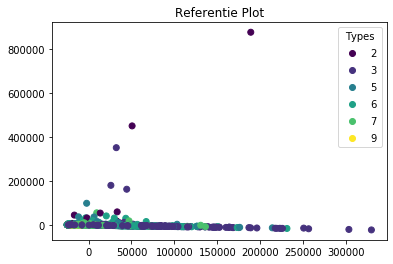

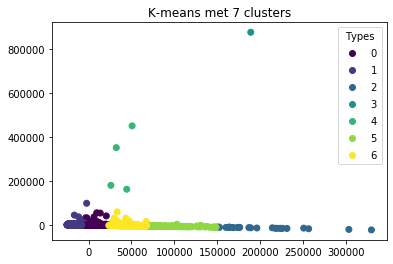

In [31]:
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
labels = [types.type[int(label)] for label in counts.keys()]
plt.title('Referentie Plot')
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y)

plt.legend(*scatter.legend_elements(), loc="upper right", title="Types")
plt.show()

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
plt.title('K-means met 7 clusters')
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.legend(*scatter.legend_elements(), loc="upper right", title="Types")
plt.show()

# 5. Evaluatie en vergelijken van de gebruikte modellen

## Modellen aanmaken en bekijken

hieronder worden alle modellen voorgesteld in een simpele weergave zonder parameter tuning.

### Data bekijken

De data bekijken op deze manier is heel erg handig om te zien hoe de verschillende types zich uitspreken in de verschillende features. Aan de hand hiervan heb ik mijn uiteindelijke modellen gekozen.

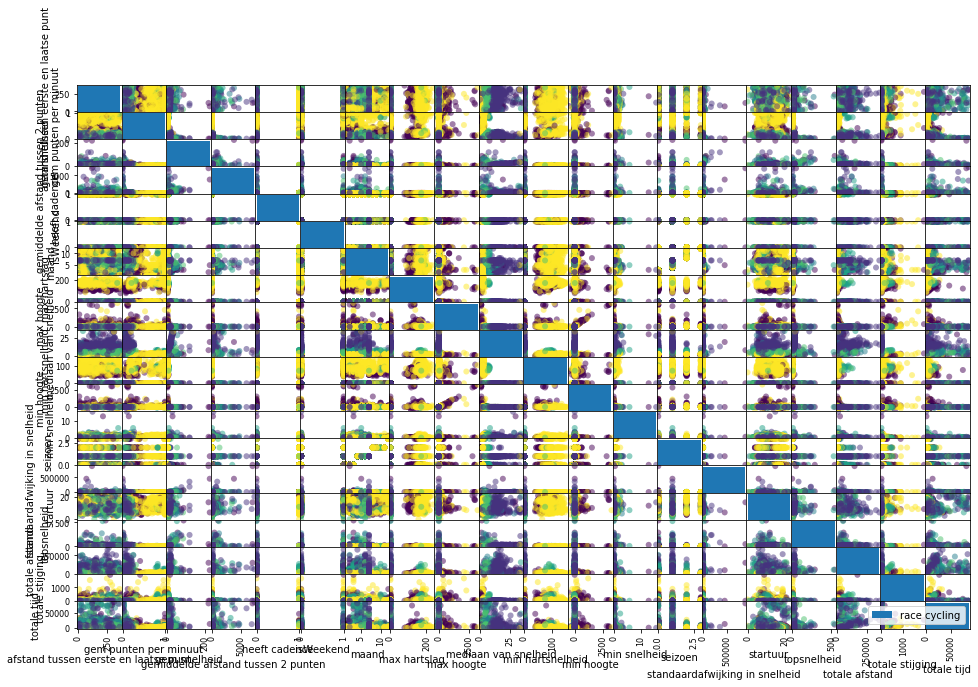

In [32]:
labels = [types.type[int(label)] for label in counts.keys()]
plot = pd.plotting.scatter_matrix(X, c=y, label=labels, figsize=(16, 10), marker='o', hist_kwds={'bins': 1})
plt.legend(labels, loc=1)
plt.show()

### KNN-model om type te berekenen

Hier is een voorstelling zonder parameter tuning hoe het KNN model presteert.

In [33]:
neighbors = 15

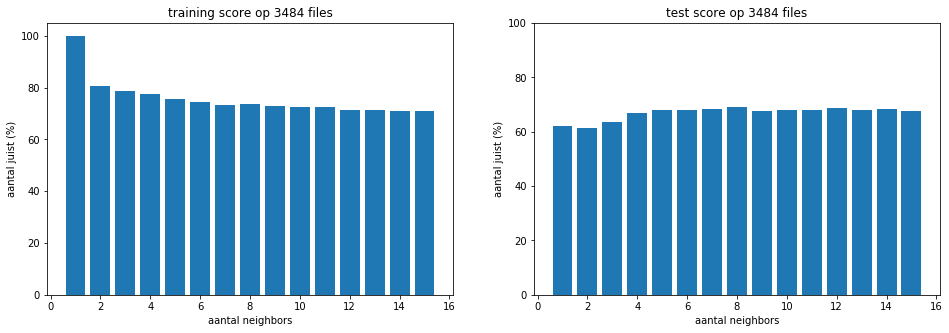

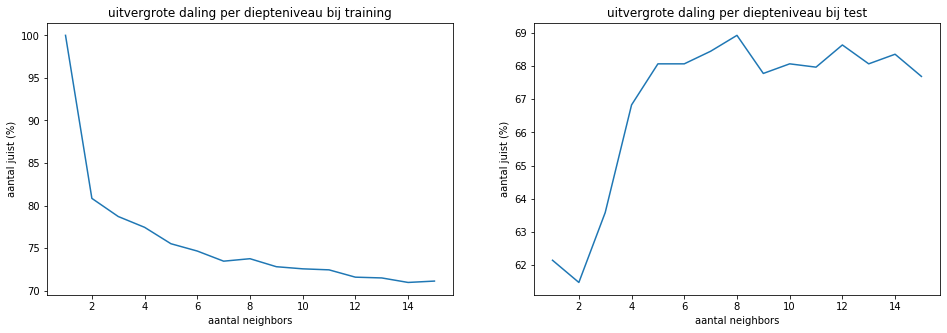

In [34]:
trainingScore = []
testScore = []

for n in range(1, neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    
    trainingScore.append(round(knn.score(X_train,y_train) * 100, 2))
    testScore.append(round(knn.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, neighbors+1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score op ' + str(len(X)) + ' files')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('aantal neighbors')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' files')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('aantal neighbors')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.plot(objects, trainingScore)
ax1.set_title('uitvergrote daling per diepteniveau bij training')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('aantal neighbors')

ax2.plot(objects, testScore)
ax2.set_title('uitvergrote daling per diepteniveau bij test')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('aantal neighbors')
plt.show()

### decision tree om type te berekenen

Hier is een voorbeeld van decision tree resultaten zonder parameter tuning.

In [35]:
diepte = 15

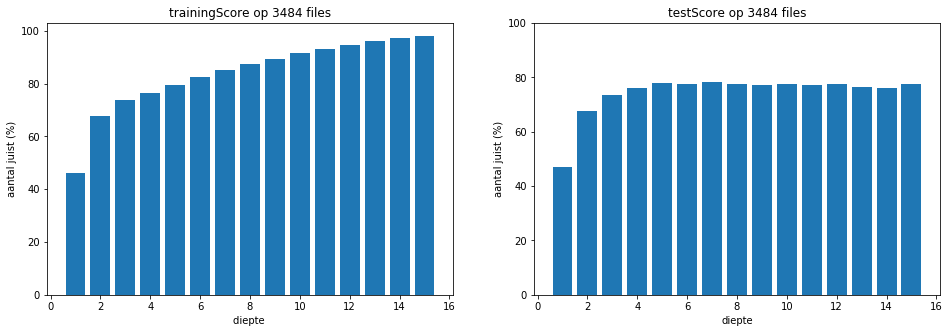

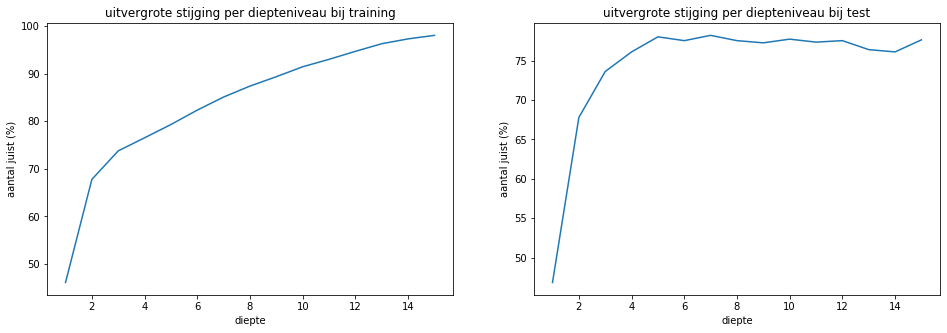

In [36]:
trainingScore = []
testScore = []

for n in range(1, diepte+1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScore.append(round(treeModel.score(X_train,y_train) * 100, 2))
    testScore.append(round(treeModel.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, diepte+1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('trainingScore op ' + str(len(X)) + ' files')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('diepte ')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' files')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('diepte')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.plot(objects, trainingScore)
ax1.set_title('uitvergrote stijging per diepteniveau bij training')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScore)
ax2.set_title('uitvergrote stijging per diepteniveau bij test')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('diepte')
plt.show()

### random forest om type te berekenen

Hieronder een kleine voorstelling hoe random forest zonder parameter tuning presteerd.

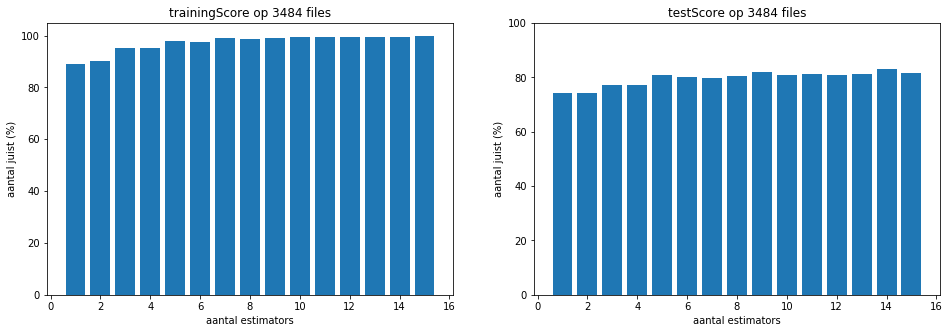

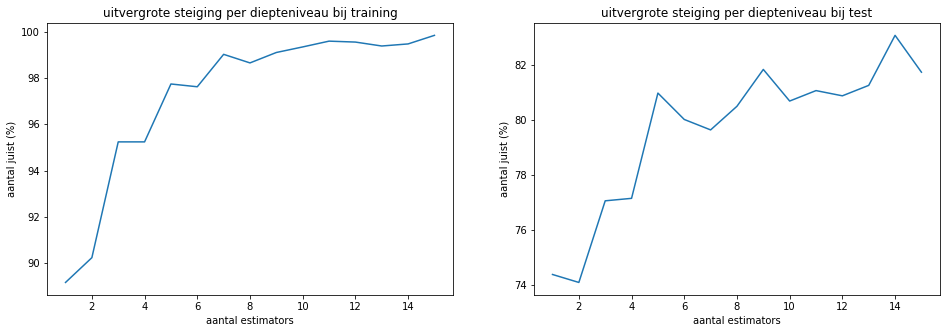

In [38]:
trainingScore = []
testScore = []

for n in range(1, diepte+1):
    clf = RandomForestClassifier(n_estimators=n).fit(X_train,y_train)
    
    trainingScore.append(round(clf.score(X_train,y_train) * 100, 2))
    testScore.append(round(clf.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, diepte+1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('trainingScore op ' + str(len(X)) + ' files')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('aantal estimators')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' files')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('aantal estimators')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.plot(objects, trainingScore)
ax1.set_title('uitvergrote steiging per diepteniveau bij training')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('aantal estimators')

ax2.plot(objects, testScore)
ax2.set_title('uitvergrote steiging per diepteniveau bij test')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('aantal estimators')
plt.show()

### Gradient Boosting om type te berekenen

Hieronder een voorbeeld hoe Gradient Boosting presteerd zonder parameter tuning.

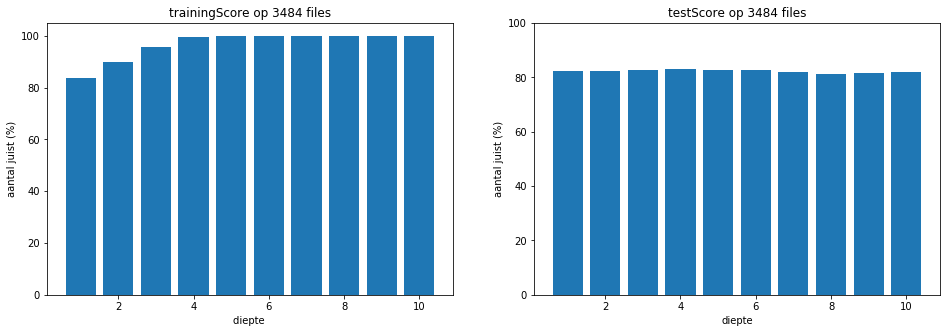

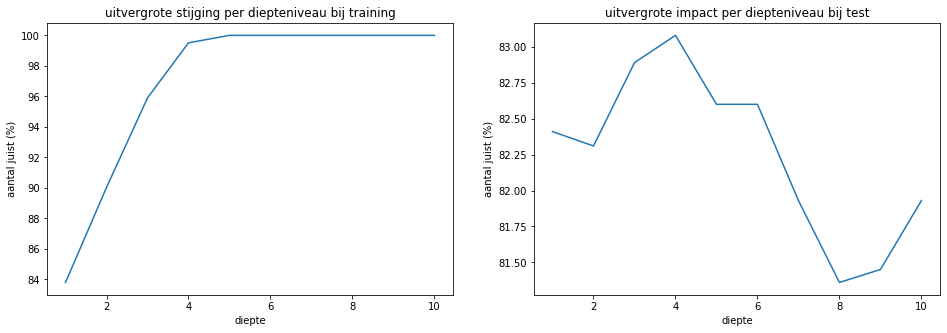

In [39]:
trainingScore = []
testScore = []

diepte = 10

for n in range(1, diepte+1):
    gbrt = GradientBoostingClassifier(random_state=42, max_depth=n).fit(X_train, y_train)
    
    trainingScore.append(round(gbrt.score(X_train,y_train) * 100, 2))
    testScore.append(round(gbrt.score(X_test,y_test) * 100, 2))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
objects = range(1, diepte+1)

ax1.bar(objects, trainingScore)
ax1.set_title('trainingScore op ' + str(len(X)) + ' files')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('diepte ')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' files')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('diepte')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))
ax1.plot(objects, trainingScore)
ax1.set_title('uitvergrote stijging per diepteniveau bij training')
ax1.set_ylabel('aantal juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScore)
ax2.set_title('uitvergrote impact per diepteniveau bij test')
ax2.set_ylabel('aantal juist (%)')
ax2.set_xlabel('diepte')
plt.show()

### logistic regression om type te berekenen

In [40]:
logisticRegr = LogisticRegression(solver='liblinear', multi_class = 'auto')
logisticRegr.fit(X_train, y_train)

print('trainingsscore: ',round(logisticRegr.score(X_train,y_train) * 100, 2))
print('testscore: ', round(logisticRegr.score(X_test,y_test) * 100, 2))

trainingsscore:  70.22
testscore:  70.94


## Modellen verbeteren

### cross-validatie

#### cross-validatie van een KNN-model

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(knn, X, y, cv=kfold, return_train_score=True))
scores = cross_val_score(knn, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
res_df

Average cross-validation score: 0.67


,fit_time,score_time,test_score,train_score
0,0.005000,0.034000,0.645624,0.759598
1,0.003999,0.021000,0.684362,0.761392
2,0.004000,0.020999,0.682927,0.749910
3,0.003000,0.021000,0.652798,0.764980
4,0.004000,0.021000,0.659483,0.758608


In [43]:
lr = LinearRegression().fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(lr, X, y, cv=kfold, return_train_score=True))
scores = cross_val_score(lr, X, y)

res_df
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.21


In [44]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

res_df = pd.DataFrame(cross_validate(tree, X, y, cv=kfold, return_train_score=True))
scores = cross_val_score(tree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
res_df

Average cross-validation score: 0.76


,fit_time,score_time,test_score,train_score
0,0.015001,0.001,0.756098,0.810190
1,0.014999,0.001,0.773314,0.809473
2,0.015000,0.000,0.806313,0.804449
3,0.015000,0.001,0.758967,0.808037
4,0.014000,0.001,0.785920,0.809541


### Gridsearch

hieronder wordt de data klaargezet om te berekenen, alsook een veld voor de beste score en de beste methode / model. Deze zal later gebruikt worden om het beste model in detail toe te lichten. Uiteindelijk wordt de gridsearch methode gebruikt om de parameters te tunen. Voor mij is dit meest efficiente en goede uitkomst.

In [45]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=42)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

topscore = 0
bm = 0

Size of training set: 1959   size of validation set: 654   size of test set: 871



#### Gridsearch bij KNN

In [46]:
best_score = 0

for n in range(1, 11):
        knn = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
        score = knn.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'n_neighbors': n}
            if score > topscore:
                topscore = score
                bm = knn

print("Best parameters: ", best_parameters)

knn = KNeighborsClassifier(**best_parameters).fit(X_trainval, y_trainval)
training_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)

print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Best parameters:  {'n_neighbors': 10}

Training set score with best parameters : 0.74
Best score on validation set: 0.71
Test set score with best parameters: 0.65


#### Gridsearch bij Decision tree

In [47]:
best_score = 0

for depth in range(1, 15):
    for rs in [0,5,10,20,42]:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
        tree.fit(X_train, y_train)
        score = tree.score(X_valid, y_valid)
        
        if score > best_score:
            best_score = score
            best_parameters = {'max_depth': depth, 'random_state': rs}
            if score > topscore:
                topscore = score
                bm = tree

print("Best parameters: ", best_parameters)

tree = DecisionTreeClassifier(**best_parameters)
tree.fit(X_trainval, y_trainval)
training_score = tree.score(X_train, y_train)
test_score = tree.score(X_test, y_test)

print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Best parameters:  {'max_depth': 6, 'random_state': 0}

Training set score with best parameters : 0.84
Best score on validation set: 0.80
Test set score with best parameters: 0.78


#### gridsearch bij Random Forest

In [48]:
best_score = 0

for n in range(1, 50):
    for rs in [0,5,10,20,42]:
        rfc = RandomForestClassifier(n_estimators=n, random_state=rs).fit(X_train, y_train)
        score = rfc.score(X_valid, y_valid)

        if score > best_score:
            best_score = score
            best_parameters = {'n_estimators': n, 'random_state':rs}
            if score > topscore:
                topscore = score
                bm = rfc

print("Best parameters: ", best_parameters)

rfc = RandomForestClassifier(**best_parameters).fit(X_trainval, y_trainval)
training_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Best parameters:  {'n_estimators': 23, 'random_state': 10}

Training set score with best parameters : 1.00
Best score on validation set: 0.83
Test set score with best parameters: 0.80


#### gridsearch bij Gradient Boosted Regression Trees

**Opgelet** Deze berekening kan 5min duren.

In [49]:
best_score = 0

for n in range(1, 15):
        for rs in [0,5,10,20,42]:
            gbrt = GradientBoostingClassifier(random_state=rs, max_depth=n).fit(X_train, y_train)
            score = gbrt.score(X_valid, y_valid)

            if score > best_score:
                best_score = score
                best_parameters = {'max_depth': n, 'random_state': rs}
                if score > topscore:
                    topscore = score
                    bm = gbrt

print("Best parameters: ", best_parameters)

gbrt = RandomForestClassifier(**best_parameters).fit(X_trainval, y_trainval)
training_score = gbrt.score(X_train, y_train)
test_score = gbrt.score(X_test, y_test)

print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

Best parameters:  {'max_depth': 3, 'random_state': 5}

Training set score with best parameters : 0.78
Best score on validation set: 0.83
Test set score with best parameters: 0.74


# Beste Model

Hieronder wordt het beste model van alle voorgaande weergeven. Er worden ook wat informatieve grafieken met de voorspelde data.

In [50]:
training_score = bm.score(X_train, y_train)
test_score = bm.score(X_test, y_test)
print("beste model:", bm)
print("\nTraining set score with best parameters : {:.2f}".format(training_score))
print("Best score on validation set: {:.2f}".format(best_score))
print("Test set score with best parameters: {:.2f}".format(test_score))

beste model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=5, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Training set score with best parameters : 0.98
Best score on validation set: 0.83
Test set score with best parameters: 0.80


Hieronder een kleine grafiek van welke features een groot verschil maken tussen de verschillende types in ons model:

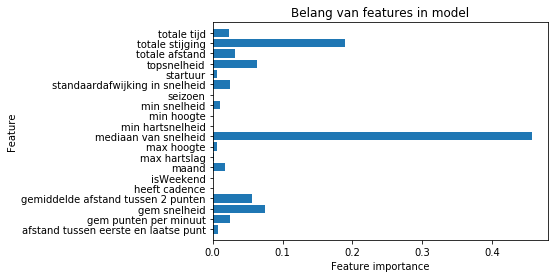

In [51]:
def feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X)
    plt.title('Belang van features in model')
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

feature_importances(bm)

Hieronder wordt de voorspelde data en de originele data in een dataframe gezet om daarna te gebruiken in de vergelijkingsgrafieken.

In [52]:
results = bm.predict(X)
originalCount = Counter(y)
counts = Counter(results)
types = pd.DataFrame(data=pd.read_csv(dataPath + "/routeTypes.txt", sep='\t', index_col=0))

originalFrame = pd.DataFrame(dtype=int)

for result in originalCount:
    originalFrame = originalFrame.append({
       'type': result,
       'count': originalCount[result]
    }, ignore_index = True)

resultsFrame = pd.DataFrame(dtype=int)

for result in counts:
    resultsFrame = resultsFrame.append({
       'type': result,
       'count': counts[result]
    }, ignore_index = True)

originalFrame = originalFrame.sort_values('type')
resultsFrame = resultsFrame.sort_values('type')

## vergelijking originele data vs voorspelde data

Hieronder wordt de voorspelde en originele data weergeven in grafieken om het verschil en de gelijkenissen te weergeven.

Text(0.5, 1.0, 'voorkomende types in voorspelde data')

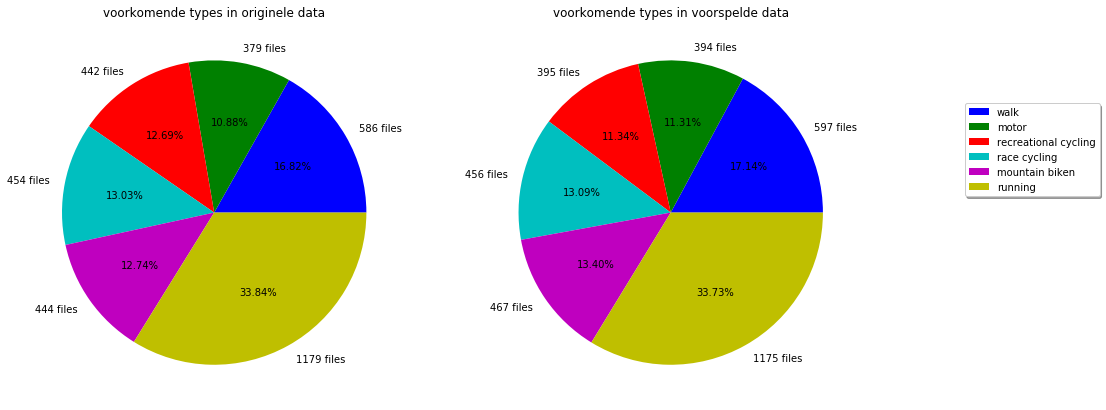

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15))
labels = originalFrame['type']
ax1.pie(originalFrame['count'],
        labels=['{} files'.format(int(value)) for value in originalFrame['count']],
        autopct='%1.2f%%', colors='bgrcmy')
ax2.legend(labels, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
ax1.set_title("voorkomende types in originele data")

labels = [types.type[int(label)] for label in resultsFrame['type']]
ax2.pie(resultsFrame['count'],
        labels=['{} files'.format(int(value)) for value in resultsFrame['count']],
        autopct='%1.2f%%', colors='bgrcmy')
ax2.legend(labels, loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
ax2.set_title("voorkomende types in voorspelde data")

hier nog een barchart vergeleken met originele barchart


Text(0.5, 0, 'types')

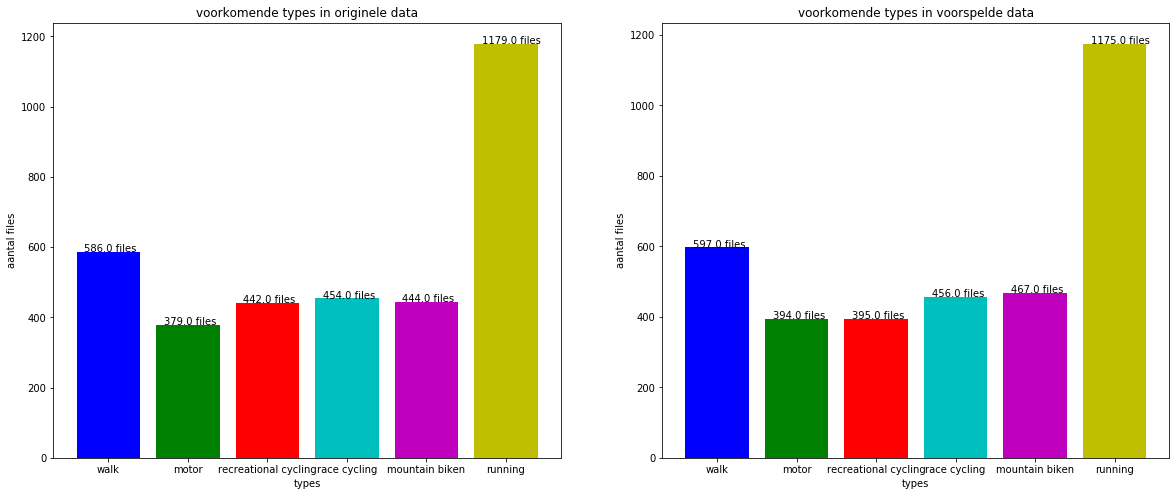

In [54]:
print('hier nog een barchart vergeleken met originele barchart')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

labels = [types.type[int(label)] for label in originalFrame['type']]
bars = ax1.bar(labels, originalFrame['count'], color='bgrcmy')
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + 0.1, yval, str(yval) + ' files')
ax1.set_title("voorkomende types in originele data")
ax1.set_ylabel('aantal files')
ax1.set_xlabel('types')

labels = [types.type[int(label)] for label in resultsFrame['type']]
bars = ax2.bar(labels, resultsFrame['count'], color='bgrcmy')
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + 0.1, yval, str(yval) + ' files')
ax2.set_title("voorkomende types in voorspelde data")
ax2.set_ylabel('aantal files')
ax2.set_xlabel('types')

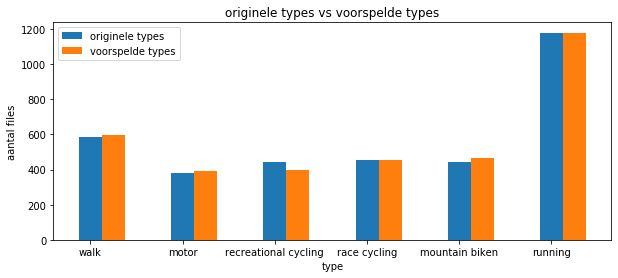

In [55]:
width =0.25

fig, ax = plt.subplots(figsize = (10,4))

ax.bar(np.arange(len(originalFrame['type'])), originalFrame['count'], width=width)
ax.bar(np.arange(len(resultsFrame['type']))+ width, resultsFrame['count'], width=width)
ax.set_xlabel('type')
ax.set_xticks(np.arange(len(originalFrame['type'])))
ax.set_xticklabels(labels)
ax.set_ylabel('aantal files')
ax.legend(["originele types", "voorspelde types"])
ax.set_title('originele types vs voorspelde types')
plt.show()

# 6. Rapporteren

## besluit

Uit de voorspelde data is duidelijk te zien dat de decision trees met getunde parameters uiteindelijk het beste scoren, vooral de Random Forest en deGradient boosted Regression scoren hoog. De data lijkt zeer goed voorspeld. Er is wel nog wat verwarring tussen het type "walk" en het type "recreational cycling". Dit heb ik uiteindelijk verholpen met de toevoeging van de feature "hasCad", deze feature bestaat uit een binaire variabele die aanduid of de route een cadence bevat. Cadence wordt uitgedrukt in aantal stappen per minuut, dus een fietser kan even traag fietsen als een wandelaar, maar zal geen cadence hebben. Alle andere features dragen natuurlijk ook bij aan de decision tree. 

## Bronnen

- [How to disable python warnings](<https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings#14463362>)
- [gpxpy source code on GitHub](<https://github.com/tkrajina/gpxpy/blob/c92a09ff50bbb41b11e13ee7fe97bd7d89103a68/gpxpy/gpx.py>)
- [How tracking apps analyse your GPS data: a hands-on tutorial in Python](<https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d>)
- [gpxpy on PyPI](<https://pypi.org/project/gpxpy/>)
- [gpxpy on Anaconda](<https://anaconda.org/conda-forge/gpxpy>)
- [Random forest in python](<https://datatofish.com/random-forest-python/>)
- [Visualize clusters in Python](<https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/>)

# oude ongebruikte code

### berekenen van afstand tussen 2 punten
vooraleer de snelheid tussen 2 punten kan berekend worden, moet de afstand tussen diezelfde 2 punten gekend zijn. Hieronder is een formule uitgewerkt om dit te berekenen. In verdere code wordt deze niet echt gebruikt aangezien er zeer gemakkelijk gebruik kan gemaakt worden van libraries die dit berekenen.

In [ ]:
def afstandTussenPunten(punt1, punt2):
    lat1 = punt1.latitude * math.pi / 180
    lat2 = punt2.latitude * math.pi / 180
    lon1 = punt1.longitude * math.pi / 180
    lon2 = punt2.longitude * math.pi /180
    
    r = 6378000
    
    rho1 = r * math.cos(lat1)
    z1 = r * math.sin(lat1)
    x1 = rho1 * math.cos(lon1)
    y1 = rho1 * math.sin(lon1)
    
    rho2 = r * math.cos(lat2)
    z2 = r * math.sin(lat2)
    x2 = rho2 * math.cos(lon2)
    y2 = rho2 * math.sin(lon2)

    dot = (x1 * x2 + y1 * y2 + z1 * z2)
    cos_theta = dot / (r * r)
    
    try:
        theta = math.acos(cos_theta)
        return (r * theta)
    except:
        return 0
    # Distance in Metres
    
    
def berekenSnelheid(punt1, punt2):
    distance = afstandTussenPunten(punt1, punt2)
    tijdVerschil = punt2.time - punt1.time
    snelheid = distance / tijdVerschil.total_seconds()
    return snelheid